# A Bayesian Neural Net Demo for Turing

## Get started

Let's start by loading packages. 

`Turing` is our PPL framework and other pacakges are for plotting purpose.

In [1]:
using Turing, Distributions
using Reactive, Interact, Gadfly
include(Pkg.dir("Turing")*"/doc/source/notebooks/data/bayesNN-helper.jl");

INFO: Precompiling module Reactive.


## The Model

The Neural Network defined in this demo is shwon in the figure below.

<img src="fig/bnn.png">

## Training Data

Next, let's generate some training data and make a plotting.

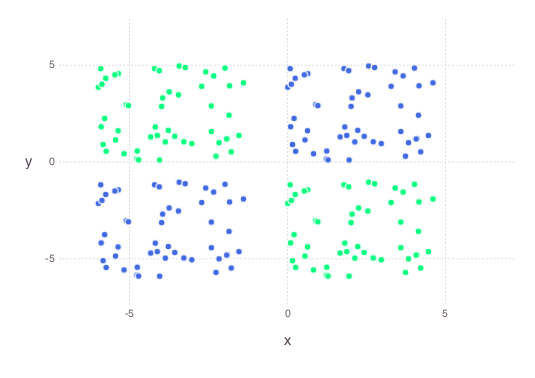

In [2]:
# Generating 200 training data
N = 200
M = round(Int64, N / 4)
x1s = rand(M) * 5
x2s = rand(M) * 5
xt1s = Array([[x1s[i]; x2s[i]] for i = 1:M])
append!(xt1s, Array([[x1s[i] - 6; x2s[i] - 6] for i = 1:M]))
xt0s = Array([[x1s[i]; x2s[i] - 6] for i = 1:M])
append!(xt0s, Array([[x1s[i] - 6; x2s[i]] for i = 1:M]))

xs = [xt1s; xt0s];
ts = [ones(M); ones(M); zeros(M); zeros(M)];

# Plot data points
d1_layer = layer(x=map(e -> e[1], xt1s), y=map(e -> e[2], xt1s), Geom.point, Theme(default_color=colorant"royalblue"))
d2_layer = layer(x=map(e -> e[1], xt0s), y=map(e -> e[2], xt0s), Geom.point, Theme(default_color=colorant"springgreen"))

plot(d1_layer, d2_layer, Coord.Cartesian(xmin=-7, xmax=7, ymin=-7, ymax=7))

## Model in Turing

The neural network is defined in Turing as below.

In [3]:
# Define the model
alpha = 0.16            # regularizatin term
var = sqrt(1.0 / alpha) # variance of the Gaussian prior
@model bnn(ts) = begin
    w11 ~ MvNormal([0; 0], [var 0; 0 var])
    w12 ~ MvNormal([0; 0], [var 0; 0 var])
    w13 ~ MvNormal([0; 0], [var 0; 0 var])
    w14 ~ MvNormal([0; 0], [var 0; 0 var])
    b1 ~ MvNormal([0 ;0; 0; 0], [var 0 0 0; 0 var 0 0; 0 0 var 0; 0 0 0 var])

    w21 ~ MvNormal([0 ;0; 0; 0], [var 0 0 0; 0 var 0 0; 0 0 var 0; 0 0 0 var])
    w22 ~ MvNormal([0 ;0; 0; 0], [var 0 0 0; 0 var 0 0; 0 0 var 0; 0 0 0 var])
    b2 ~ MvNormal([0 ;0], [var 0; 0 var])

    wo ~ MvNormal([0; 0], [var 0; 0 var])
    bo ~ Normal(0, var)

    for i = rand(1:N, 25)
        p = nn(xs[i], b1, w11, w12, w13, w14, b2, w21, w22, bo, wo)
        y[i] ~ Bernoulli(p)
    end
    return b1, w11, w12, w13, w14, b2, w21, w22, bo, wo
end

bnn (generic function with 4 methods)

## Training

Let's call `sample()` to train the model.

Note this model has 25 dimensions and would take ~25s to get 1000 samples.

In [4]:
@time chain = @sample(bnn(ts), HMC(1000, 0.1, 5));

LoadError: MethodError: no method matching keys(::Array{Float64,1})[0m
Closest candidates are:
  keys([1m[31m::DataFrames.Index[0m) at /Users/yebai/.julia/v0.5/DataFrames/src/other/index.jl:58
  keys([1m[31m::Mamba.Model[0m) at /Users/yebai/.julia/v0.5/Mamba/src/model/model.jl:53
  keys([1m[31m::Mamba.Model[0m, [1m[31m::Symbol[0m, [1m[31m::Any...[0m) at /Users/yebai/.julia/v0.5/Mamba/src/model/model.jl:56
  ...[0m

## Prediction

The Bayesian prediciton result is then shown below.

This is an interactive plot, in which you can change the ratio of samples in the chain to see the evoluation of training.

In [5]:
@manipulate for
    ratio = 0.01:0.05:1
    p_layer = layer(z=(x,y) -> predict([x, y], chain, ratio), x=linspace(-6,6,25), y=linspace(-6,6,25), Geom.contour)
    plot(d1_layer, d2_layer, p_layer, Coord.cartesian(xmin=-6, xmax=6, ymin=-6, ymax=6))
end

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(0.46, nactions=1),"ratio",0.46,"0.46",Interact.OptionDict(DataStructures.OrderedDict("0.01"=>0.01,"0.060000000000000005"=>0.06,"0.11"=>0.11,"0.16000000000000003"=>0.16,"0.21000000000000002"=>0.21,"0.26"=>0.26,"0.31000000000000005"=>0.31,"0.36000000000000004"=>0.36,"0.41000000000000003"=>0.41,"0.46"=>0.46…),Dict(0.26=>"0.26",0.66=>"0.66",0.51=>"0.51",0.76=>"0.76",0.56=>"0.56",0.01=>"0.01",0.91=>"0.91",0.81=>"0.81",0.31=>"0.31000000000000005",0.46=>"0.46"…)),Any[],Any[],true,"horizontal")

UndefVarError: UndefVarError: chain not defined